# CS-GY 9223-D: Deep Learning Homework 2
Due on Friday, 12th March 2019, 11:55 PM

This homework can be done in pairs.

Write down the UNIs (NetIDs) of your group (if applicable)

Member 1: Karanpreet wadhwa, ks352

Member 2: Namit mohale, nm3191

### Create validation data

In [1]:
import os
import numpy as np
import glob

In [2]:
data_path = '../input/'
TRAIN = '../input/images_training_rev1/images_training_rev1'
TEST = '../input/images_test_rev1/images_test_rev1'
LABELS = '../input/training_solutions_rev1/training_solutions_rev1.csv'
# g = glob.glob(data_path+'train/*.jpg')
# shuf = np.random.permutation(g)
# for i in range(2000):
#     os.rename(shuf[i], data_path+ 'valid/' + shuf[i].split("/")[-1])

## Building VGG model in Keras

In [3]:
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda, Reshape
from keras.layers import Input, MaxoutDense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation,BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import applications
import matplotlib.pylab as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
def ConvBlock(layers, model, filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1),data_format='channels_first'))  # zero padding of size 1
        model.add(Convolution2D(filters, kernel_size=(3,3),data_format='channels_first'))  # 3x3 filter size 
        model.add(BatchNormalization())
        model.add(Activation("relu"))
    model.add(MaxPooling2D((1,1), strides=(2,2),data_format='channels_first'))

def FCBlock(model):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(3,106,106)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 1024)

    
    model.add(Flatten())
    FCBlock(model)
    
    model.add(Dense(37, activation = 'sigmoid'))
    print(model.summary())
    return model

# Compile 
optimizer = Adam(lr=1e-5)
model = VGG_16()
#Adding custom Layers 
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', 'mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 106, 106)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 108, 108)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 106, 106)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 106, 106)      424       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 106, 106)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 108, 108)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 106, 106)      36928     
__________

In [5]:
from random import shuffle
from scipy.misc import imresize  

class data_getter:    
    """
    Creates a class for handling train/valid/test data paths,
    training labels and image IDs.
    Useful for switching between sample and full datasets.
    """
    def __init__(self, path):    
        self.path = path 
        self.train_path = TRAIN
        #self.val_path = path + "valid"
        self.test_path = TEST
        
        def get_paths(directory):
            return [f for f in os.listdir(directory)]
        
        self.training_images_paths = get_paths(self.train_path)
        #self.validation_images_paths = get_paths(self.val_path)
        self.test_images_paths = get_paths(self.test_path)    
        
        def get_all_solutions():
        ### Import solutions file and load into self.solutions
            import csv
            all_solutions = {}
            #/'training_solutions_rev1.csv'
            with open(LABELS, 'r') as f:
                reader = csv.reader(f, delimiter=",")
                next(reader)
                for i, line in enumerate(reader):
                    all_solutions[line[0]] = [float(x) for x in line[1:]]
            return all_solutions
        
        self.all_solutions = get_all_solutions()

    def get_id(self,fname):
        return fname.replace(".jpg","").replace("data","")
        
    def find_label(self,val):
        return self.all_solutions[val]
        
# fetcher = data_getter('data/sample/')
fetcher = data_getter(data_path)
print(fetcher.train_path)

../input/images_training_rev1/images_training_rev1


In [6]:
def process_images(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    for c, path in enumerate(paths):
        img = plt.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        arr[c] = img
    return arr

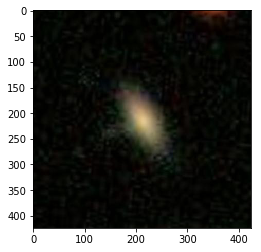

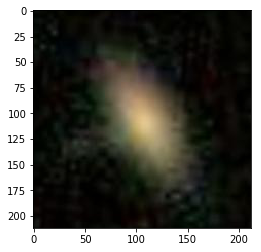

In [7]:
## Print some before/after processing images

#process_images([fetcher.train_path + '/' + fetcher.training_images_paths[100]])
im = plt.imread(fetcher.train_path + '/' + fetcher.training_images_paths[0])
# print(im.shape)

plt.imshow(im)
plt.show()
im = im.T[:,106:106*3,106:106*3] #crop 424x424 -> 212x212

plt.imshow(im.T)

In [8]:
# Create generator that yields (current features X, current labels y)
def BatchGenerator(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images([getter.train_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
            
def ValBatchGenerator(getter):
    while 1:
        for f in getter.validation_images_paths:
            X_train = process_images([getter.val_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
                        

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from skimage.filters import gaussian 
import random 
from skimage.transform import resize

IDG2 = ImageDataGenerator()
def process_images2(paths):
    """
    Import image at 'paths', decode, centre crop and prepare for batching. 
    """
    count = len(paths)
    length_paths = len(paths)
    arr = np.zeros(shape=(count,3,106,106))
    
    
    fh = bool(random.getrandbits(1))
    fv = bool(random.getrandbits(1))
    
    transform_parameters ={'theta': theta, 'flip_horizontal': fh,  'flip_vertical': fv }
    
    for c, path in enumerate(paths):
        img = plt.imread(path).T
        img = img[:,106:106*3,106:106*3] #crop 424x424 -> 212x212
        img = imresize(img,size=(106,106,3),interp="cubic").T # downsample to half res
        img = IDG2.apply_transform(img, transform_parameters)
        arr[c] = img
    
    return arr

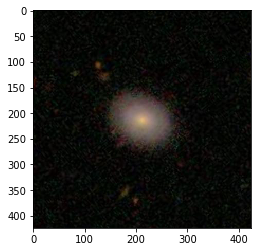

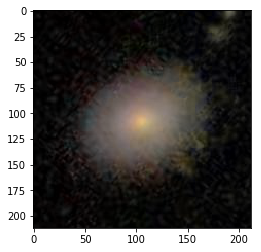

In [10]:
## Print some before/after processing images

#process_images([fetcher.train_path + '/' + fetcher.training_images_paths[100]])
im = plt.imread(fetcher.train_path + '/' + fetcher.training_images_paths[5])
# print(im.shape)
theta = int(np.pi / 180 * np.random.uniform(-90.0, 90))
fh = bool(random.getrandbits(1))
fv = bool(random.getrandbits(1))
transform_parameters ={'theta': theta, 'flip_horizontal': fh,  'flip_vertical': fv }

plt.imshow(im)
plt.show()
im = im.T[:, 106:106*3,106:106*3] #crop 424x424 -> 212x212
#im = im.T
im = IDG2.apply_transform(im, transform_parameters)

plt.imshow(im.T)

In [11]:
# Create generator that yields (current features X, current labels y)
def BatchGenerator2(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images2([getter.train_path + '/' + fname for fname in [f]])
            # X_train = np.reshape(X_train, (1, 106, 106, 3))
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            # y_train = np.hstack((y_train, y_train, y_train, y_train))
            yield (X_train, y_train)
            
def ValBatchGenerator2(getter):
    while 1:
        for f in getter.training_images_paths:
            X_train = process_images2([getter.train_path + '/' + fname for fname in [f]])
            id_ = getter.get_id(f)
            y_train = np.array(getter.find_label(id_))
            y_train = np.reshape(y_train,(1,37))
            yield (X_train, y_train)
                        

### Train model

In [12]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
    
early_stopping = EarlyStopping(monitor='loss', patience=7, verbose=1, mode='auto')
history = LossHistory()

#from keras.callbacks import ModelCheckpoint
#checkpointer = ModelCheckpoint(monitor='loss',filepath='../input/tmp/weights.hdf5', verbose=1, save_best_only=True)

batch_size = 32
steps_to_take = int(len(fetcher.training_images_paths)/batch_size)
#val_steps_to_take = int(len(fetcher.validation_images_paths)/batch_size)
                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.
        
        
#model = load_model('tmp/weights.hdf5')

hist = model.fit_generator(BatchGenerator(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=150,
                    verbose=2,
                    shuffle=True,
                    callbacks=[history,early_stopping],
                   )
hist2=model.fit_generator(BatchGenerator2(fetcher),
                    samples_per_epoch=steps_to_take, 
                    nb_epoch=150,
                    verbose=2,
                    shuffle=True,
                    callbacks=[history,early_stopping],
)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, shuffle=True, callbacks=[<__main__..., steps_per_epoch=1924, epochs=150)`


Epoch 1/150


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


 - 121s - loss: 0.0367 - acc: 0.5244 - mean_squared_error: 0.0367
Epoch 2/150
 - 112s - loss: 0.0292 - acc: 0.5281 - mean_squared_error: 0.0292
Epoch 3/150
 - 113s - loss: 0.0274 - acc: 0.5416 - mean_squared_error: 0.0274
Epoch 4/150
 - 112s - loss: 0.0250 - acc: 0.5577 - mean_squared_error: 0.0250
Epoch 5/150
 - 112s - loss: 0.0232 - acc: 0.5447 - mean_squared_error: 0.0232
Epoch 6/150
 - 113s - loss: 0.0217 - acc: 0.5696 - mean_squared_error: 0.0217
Epoch 7/150
 - 112s - loss: 0.0221 - acc: 0.5541 - mean_squared_error: 0.0221
Epoch 8/150
 - 112s - loss: 0.0210 - acc: 0.5603 - mean_squared_error: 0.0210
Epoch 9/150
 - 112s - loss: 0.0204 - acc: 0.5644 - mean_squared_error: 0.0204
Epoch 10/150
 - 112s - loss: 0.0203 - acc: 0.5681 - mean_squared_error: 0.0203
Epoch 11/150
 - 112s - loss: 0.0189 - acc: 0.5660 - mean_squared_error: 0.0189
Epoch 12/150
 - 112s - loss: 0.0196 - acc: 0.5665 - mean_squared_error: 0.0196
Epoch 13/150
 - 112s - loss: 0.0200 - acc: 0.5702 - mean_squared_error: 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, shuffle=True, callbacks=[<__main__..., steps_per_epoch=1924, epochs=150)`
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 - 114s - loss: 0.0109 - acc: 0.7256 - mean_squared_error: 0.0109
Epoch 2/150
 - 115s - loss: 0.0106 - acc: 0.7323 - mean_squared_error: 0.0106
Epoch 3/150
 - 114s - loss: 0.0105 - acc: 0.7458 - mean_squared_error: 0.0105
Epoch 4/150
 - 115s - loss: 0.0106 - acc: 0.7547 - mean_squared_error: 0.0106
Epoch 5/150
 - 114s - loss: 0.0102 - acc: 0.7386 - mean_squared_error: 0.0102
Epoch 6/150
 - 114s - loss: 0.0100 - acc: 0.7625 - mean_squared_error: 0.0100
Epoch 7/150
 - 114s - loss: 0.0107 - acc: 0.7344 - mean_squared_error: 0.0107
Epoch 8/150
 - 114s - loss: 0.0100 - acc: 0.7464 - mean_squared_error: 0.0100
Epoch 9/150
 - 115s - loss: 0.0098 - acc: 0.7630 - mean_squared_error: 0.0098
Epoch 10/150
 - 115s - loss: 0.0102 - acc: 0.7328 - mean_squared_error: 0.0102
Epoch 11/150
 - 114s - loss: 0.0097 - acc: 0.7484 - mean_squared_error: 0.0097
Epoch 12/150
 - 114s - loss: 0.0104 - acc: 0.7542 - mean_squared_error: 0.0104
Epoch 13/150
 - 115s - loss: 0.0108 - acc: 0.7500 - mean_squared_error: 0

### Plot training/validation loss

### Model Predict

In [14]:
# # Load best model weights
# from keras.models import load_model
# model = load_model('tmp/weights.hdf5')

In [15]:
def TestBatchGenerator(getter):
    while 1:
        for f in getter.test_images_paths:
            X_train = process_images([getter.test_path + '/' + fname for fname in [f]])
            yield (X_train)

predictions = model.predict_generator(TestBatchGenerator(fetcher),
                       val_samples = len(fetcher.test_images_paths),
                        max_q_size = 32,)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `predict_generator` call to the Keras 2 API: `predict_generator(<generator..., steps=600, max_queue_size=32)`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load

In [16]:
predictions.shape

(600, 37)

In [17]:
header = open('../input/all_zeros_benchmark/all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for i in range(len(fetcher.test_images_paths)):
        id_ = (fetcher.get_id(fetcher.test_images_paths[i]))
        pred = predictions[i]
        outline = id_ + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")